# PatchTST, NHITS, TFT and BiTCN with Etherium (& more)

We will gather Etherium(ETH-USD), Bitcoin(BTC-USD), NASDAQ 100(^NDX), CBOE Interest Rate 10 Year T No (^TNX), Nikkei 225 (^N225), Gold Price (GLD), USD/JPY (JPY=X), S&P500 (^GSPC)

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast.core import NeuralForecast
from neuralforecast.models import PatchTST, NHITS, BiTCN, TFT, Autoformer
from neuralforecast.auto import AutoPatchTST, AutoNHITS, AutoBiTCN, AutoTFT, AutoAutoformer
from neuralforecast.losses.pytorch import DistributionLoss, MSE, MAE
from utilsforecast.plotting import plot_series

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import seaborn as sns
sns.set_theme()

Fetch data

In [ ]:
tickers = ['BTC-USD', 'ETH-USD', '^N225', '^NDX', '^GSPC', '^TNX', 'GLD', 'JPY=X']
data = yf.download(tickers, start='2017-01-01', end='2025-12-31', interval='1d')
data.to_csv('data/market_data.csv')

Load data

In [4]:
data = pd.read_csv('data/market_data.csv', header=[0,1], index_col=0, parse_dates=True)
data.head()

Price             Close                      ...       Volume                   
Ticker          BTC-USD ETH-USD         GLD  ...        ^N225          ^NDX ^TNX
Date                                         ...                                
2017-01-01   998.325012     NaN         NaN  ...          NaN           NaN  NaN
2017-01-02  1021.750000     NaN         NaN  ...          NaN           NaN  NaN
2017-01-03  1043.839966     NaN  110.470001  ...          NaN  1.887670e+09  0.0
2017-01-04  1154.729980     NaN  110.860001  ...  163500000.0  1.885490e+09  0.0
2017-01-05  1013.380005     NaN  112.580002  ...  134500000.0  1.799170e+09  0.0

[5 rows x 40 columns]

Pre-processing

In [5]:
data = data['Close'].ffill().dropna()

data.index = pd.to_datetime(data.index)

data['day_week'] = data.index.dayofweek

df = data.reset_index(names='ds')

df = df.melt(id_vars=['ds', 'day_week'], var_name='unique_id', value_name='y')

df.head()


,ds,day_week,unique_id,y
0,2017-11-09,3,BTC-USD,7143.580078
1,2017-11-10,4,BTC-USD,6618.140137
2,2017-11-11,5,BTC-USD,6357.600098
3,2017-11-12,6,BTC-USD,5950.069824
4,2017-11-13,0,BTC-USD,6559.490234


In [6]:
static_df = pd.DataFrame({
    'unique_id': ['BTC-USD', 'ETH-USD', '^N225', '^NDX', '^GSPC', '^TNX', 'GLD', 'JPY=X'],
    'crypto': [1, 1, 0, 0, 0, 0, 0, 0],
    'equity': [0, 0, 1, 1, 1, 0, 0, 0],
    'bond': [0, 0, 0, 0, 0, 1, 0, 0],
    'gold': [0, 0, 0, 0, 0, 0, 1, 0],
    'forex': [0, 0, 0, 0, 0, 0, 0, 1],
})

static_df

,unique_id,crypto,equity,bond,gold,forex
0,BTC-USD,1,0,0,0,0
1,ETH-USD,1,0,0,0,0
2,^N225,0,1,0,0,0
3,^NDX,0,1,0,0,0
4,^GSPC,0,1,0,0,0
5,^TNX,0,0,1,0,0
6,GLD,0,0,0,1,0
7,JPY=X,0,0,0,0,1


In [ ]:
# Auto 
horizon = 14

def config_patchTST(trial):
    return {
            "input_size": trial.suggest_categorical("input_size", (14*6, 14*8, 14*12)),
            "stride": trial.suggest_categorical("stride", (1, 2, 7, 14)),
            "patch_len": trial.suggest_categorical("patch_len", (1, 4, 7, 14)),
            "revin": trial.suggest_categorical("revin", (True, False)),
            "scaler_type": 'robust',
            "learning_rate": trial.suggest_float("learning_rate", low=1e-4, high=1e-2, log=True),       
            "random_seed": trial.suggest_int("random_seed", 1, 10), 
            "max_steps": 1000,
            }

def config_tft(trial):
    return {
            "input_size": trial.suggest_categorical("input_size", (14*6, 14*8, 14*12)),
            "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32, 64]),
            "n_head": trial.suggest_categorical("n_head", [1, 2, 4]),
            "grn_activation": 'ELU',
            "n_rnn_layers": trial.suggest_categorical("n_rnn_layers", [1, 2, 3]),
            "rnn_type": 'lstm',
            "max_steps": 1000,
            "learning_rate": trial.suggest_float("learning_rate", low=1e-4, high=1e-2, log=True),  
            "futr_exog_list": ['day_week'], # <- Future exogenous variables
            "stat_exog_list": ['crypto', 'equity', 'bond', 'gold', 'forex'], # <- Static exogenous variables
            "scaler_type": 'robust',
            "random_seed": trial.suggest_int("random_seed", 1, 10), 
            }

def config_nhits(trial):
    return {
            "input_size": trial.suggest_categorical("input_size", (14*6, 14*8, 14*12)),
            "learning_rate": trial.suggest_float("learning_rate", low=1e-4  , high=1e-2, log=True),  
            "max_steps": 1000,
            "random_seed": trial.suggest_int("random_seed", 1, 10), 
            "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [[2, 2, 2], [16, 8, 1]]),
            "futr_exog_list": ['day_week'], # <- Future exogenous variables
            "stat_exog_list": ['crypto', 'equity', 'bond', 'gold', 'forex'], # <- Static exogenous variables
            "scaler_type": 'robust',
            }

def config_biTCN(trial):
    return {
            "input_size": trial.suggest_categorical("input_size", (14*6, 14*8, 14*12)),
            "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32, 64]),
            "learning_rate": trial.suggest_float("learning_rate", low=1e-4  , high=1e-2, log=True),  
            "max_steps": 1000,
            "random_seed": trial.suggest_int("random_seed", 1, 10), 
            "futr_exog_list": ['day_week'], # <- Future exogenous variables
            "stat_exog_list": ['crypto', 'equity', 'bond', 'gold', 'forex'], # <- Static exogenous variables
            "scaler_type": 'robust',
            }

# def config_autoformer(trial):
#     return {
#             "input_size": trial.suggest_categorical("input_size", (14*6, 14*8, 14*12)),
#             "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256]),
#             "n_head": trial.suggest_categorical("n_head", [2, 4, 8]),
#             "learning_rate": trial.suggest_float("learning_rate", low=1e-4  , high=1e-2, log=True),  
#             "max_steps": 1000,
#             "random_seed": trial.suggest_int("random_seed", 1, 10), 
#             "scaler_type": 'robust',
#             }

models_auto = [
            # AutoAutoformer(
            #     h=horizon,
            #     loss=MAE(),
            #     config=config_autoformer,
            #     backend='optuna',
            #     num_samples=10
            #     ),
            AutoTFT(
                h=horizon,
                loss=MAE(),
                config=config_tft,
                backend='optuna',
                num_samples=10
                ),
            AutoNHITS(
                h=horizon,
                loss=MAE(),
                config=config_nhits,
                backend='optuna',
                num_samples=10
                ),
            AutoBiTCN(
                h=horizon,
                loss=MAE(),
                config=config_biTCN,
                backend='optuna',
                num_samples=10
                ),  
            AutoPatchTST(
                h=horizon,
                loss=MAE(),
                config=config_patchTST,
                backend='optuna',
                num_samples=10
                ),
         ]

In [ ]:
nf_auto = NeuralForecast(
    models=models_auto,
    freq='D'
)
nf_auto.fit(df=df, static_df=static_df, val_size=horizon*2)

Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, v_num=64, train_loss_step=0.731, train_loss_epoch=0.731, valid_loss=621.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, v_num=64, train_loss_step=0.731, train_loss_epoch=0.731, valid_loss=621.0]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s, v_num=65, train_loss_step=0.750, train_loss_epoch=0.750, valid_loss=706.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s, v_num=65, train_loss_step=0.750, train_loss_epoch=0.750, valid_loss=706.0]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s, v_num=66, train_loss_step=1.090, train_loss_epoch=1.090, valid_loss=713.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, v_num=66, train_loss_step=1.090, train_loss_epoch=1.090, valid_loss=713.0]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s, v_num=67, train_loss_step=0.751, train_loss_epoch=0.751, valid_loss=711.0]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s, v_num=67, train_loss_step=0.751, train_loss_epoch=0.751, valid_loss=711.0]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s, v_num=68, train_loss_step=0.714, train_loss_epoch=0.714, valid_loss=767.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s, v_num=68, train_loss_step=0.714, train_loss_epoch=0.714, valid_loss=767.0]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s, v_num=69, train_loss_step=1.220, train_loss_epoch=1.220, valid_loss=766.0]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s, v_num=69, train_loss_step=1.220, train_loss_epoch=1.220, valid_loss=766.0]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s, v_num=70, train_loss_step=0.722, train_loss_epoch=0.722, valid_loss=803.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s, v_num=70, train_loss_step=0.722, train_loss_epoch=0.722, valid_loss=803.0]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s, v_num=71, train_loss_step=0.804, train_loss_epoch=0.804, valid_loss=716.0]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s, v_num=71, train_loss_step=0.804, train_loss_epoch=0.804, valid_loss=716.0]


Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s, v_num=72, train_loss_step=1.140, train_loss_epoch=1.140, valid_loss=729.0]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s, v_num=72, train_loss_step=1.140, train_loss_epoch=1.140, valid_loss=729.0]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, v_num=73, train_loss_step=0.733, train_loss_epoch=0.733, valid_loss=712.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, v_num=73, train_loss_step=0.733, train_loss_epoch=0.733, valid_loss=712.0]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, v_num=74, train_loss_step=0.678, train_loss_epoch=0.678]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s, v_num=74, train_loss_step=0.678, train_loss_epoch=0.678]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 25.08it/s, v_num=75, train_loss_step=0.180, train_loss_epoch=0.180, valid_loss=673.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s, v_num=75, train_loss_step=0.180, train_loss_epoch=0.180, valid_loss=673.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s, v_num=76, train_loss_step=0.366, train_loss_epoch=0.366, valid_loss=694.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=76, train_loss_step=0.366, train_loss_epoch=0.366, valid_loss=694.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 25.35it/s, v_num=77, train_loss_step=0.586, train_loss_epoch=0.586, valid_loss=644.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=77, train_loss_step=0.586, train_loss_epoch=0.586, valid_loss=644.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 34.70it/s, v_num=78, train_loss_step=0.313, train_loss_epoch=0.313, valid_loss=645.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 32.71it/s, v_num=78, train_loss_step=0.313, train_loss_epoch=0.313, valid_loss=645.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 31.32it/s, v_num=79, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=915.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 29.46it/s, v_num=79, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=915.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 33.76it/s, v_num=80, train_loss_step=0.225, train_loss_epoch=0.225, valid_loss=811.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s, v_num=80, train_loss_step=0.225, train_loss_epoch=0.225, valid_loss=811.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s, v_num=81, train_loss_step=0.370, train_loss_epoch=0.370, valid_loss=742.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 32.82it/s, v_num=81, train_loss_step=0.370, train_loss_epoch=0.370, valid_loss=742.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 32.97it/s, v_num=82, train_loss_step=0.328, train_loss_epoch=0.328, valid_loss=681.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s, v_num=82, train_loss_step=0.328, train_loss_epoch=0.328, valid_loss=681.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 29.50it/s, v_num=83, train_loss_step=0.196, train_loss_epoch=0.196, valid_loss=732.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 28.11it/s, v_num=83, train_loss_step=0.196, train_loss_epoch=0.196, valid_loss=732.0]


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 8, 1] which is of type list.
  warnings.warn(message)
Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 35.71it/s, v_num=84, train_loss_step=0.258, train_loss_epoch=0.258, valid_loss=934.0]   

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=84, train_loss_step=0.258, train_loss_epoch=0.258, valid_loss=934.0]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s, v_num=85, train_loss_step=0.575, train_loss_epoch=0.575] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 26.62it/s, v_num=85, train_loss_step=0.575, train_loss_epoch=0.575]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, v_num=86, train_loss_step=0.817, train_loss_epoch=0.817, valid_loss=795.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, v_num=86, train_loss_step=0.817, train_loss_epoch=0.817, valid_loss=795.0]

Seed set to 7


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s, v_num=87, train_loss_step=0.899, train_loss_epoch=0.899, valid_loss=780.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, v_num=87, train_loss_step=0.899, train_loss_epoch=0.899, valid_loss=780.0]


Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 21.94it/s, v_num=88, train_loss_step=0.994, train_loss_epoch=0.994, valid_loss=995.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s, v_num=88, train_loss_step=0.994, train_loss_epoch=0.994, valid_loss=995.0]


Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, v_num=89, train_loss_step=0.818, train_loss_epoch=0.818, valid_loss=995.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s, v_num=89, train_loss_step=0.818, train_loss_epoch=0.818, valid_loss=995.0]


Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s, v_num=90, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=673.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s, v_num=90, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=673.0]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s, v_num=91, train_loss_step=0.771, train_loss_epoch=0.771, valid_loss=726.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, v_num=91, train_loss_step=0.771, train_loss_epoch=0.771, valid_loss=726.0]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s, v_num=92, train_loss_step=1.090, train_loss_epoch=1.090, valid_loss=772.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s, v_num=92, train_loss_step=1.090, train_loss_epoch=1.090, valid_loss=772.0]

Seed set to 6


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s, v_num=93, train_loss_step=1.080, train_loss_epoch=1.080, valid_loss=704.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=93, train_loss_step=1.080, train_loss_epoch=1.080, valid_loss=704.0]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s, v_num=94, train_loss_step=1.060, train_loss_epoch=1.060, valid_loss=692.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s, v_num=94, train_loss_step=1.060, train_loss_epoch=1.060, valid_loss=692.0]


Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s, v_num=95, train_loss_step=0.891, train_loss_epoch=0.891, valid_loss=733.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s, v_num=95, train_loss_step=0.891, train_loss_epoch=0.891, valid_loss=733.0]


Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s, v_num=96, train_loss_step=1.010, train_loss_epoch=1.010]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s, v_num=96, train_loss_step=1.010, train_loss_epoch=1.010]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s, v_num=97, train_loss_step=0.890, train_loss_epoch=0.890, valid_loss=798.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s, v_num=97, train_loss_step=0.890, train_loss_epoch=0.890, valid_loss=798.0]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, v_num=98, train_loss_step=0.755, train_loss_epoch=0.755, valid_loss=635.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, v_num=98, train_loss_step=0.755, train_loss_epoch=0.755, valid_loss=635.0]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s, v_num=99, train_loss_step=0.715, train_loss_epoch=0.715, valid_loss=673.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s, v_num=99, train_loss_step=0.715, train_loss_epoch=0.715, valid_loss=673.0]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, v_num=100, train_loss_step=1.170, train_loss_epoch=1.170, valid_loss=705.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s, v_num=100, train_loss_step=1.170, train_loss_epoch=1.170, valid_loss=705.0]


Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s, v_num=101, train_loss_step=1.090, train_loss_epoch=1.090, valid_loss=705.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s, v_num=101, train_loss_step=1.090, train_loss_epoch=1.090, valid_loss=705.0]


Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s, v_num=102, train_loss_step=0.986, train_loss_epoch=0.986, valid_loss=638.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s, v_num=102, train_loss_step=0.986, train_loss_epoch=0.986, valid_loss=638.0]


Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=103, train_loss_step=0.903, train_loss_epoch=0.903, valid_loss=645.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=103, train_loss_step=0.903, train_loss_epoch=0.903, valid_loss=645.0]


Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s, v_num=104, train_loss_step=1.040, train_loss_epoch=1.040, valid_loss=670.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=104, train_loss_step=1.040, train_loss_epoch=1.040, valid_loss=670.0]


Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s, v_num=105, train_loss_step=0.672, train_loss_epoch=0.672, valid_loss=798.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s, v_num=105, train_loss_step=0.672, train_loss_epoch=0.672, valid_loss=798.0]

Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s, v_num=106, train_loss_step=1.200, train_loss_epoch=1.200, valid_loss=692.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 23.57it/s, v_num=106, train_loss_step=1.200, train_loss_epoch=1.200, valid_loss=692.0]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s, v_num=107, train_loss_step=0.697, train_loss_epoch=0.697]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s, v_num=107, train_loss_step=0.697, train_loss_epoch=0.697]


In [ ]:
nf_auto.save(path='./models/v2/',
        model_index=None,
        overwrite=True,
        save_dataset=False)

In [12]:
futr_df = pd.DataFrame(columns=['ds', 'BTC-USD', 'ETH-USD', '^N225', '^NDX', '^GSPC', '^TNX', 'GLD', 'JPY=X', 'day_week'])

futr_df['ds'] = pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=horizon, freq='D')
futr_df['day_week'] = futr_df['ds'].dt.dayofweek

futr_df = pd.melt(futr_df, id_vars=['ds', 'day_week'], var_name='unique_id', value_name='y')
futr_df = futr_df.drop(columns=['y'])

futr_df.head()

,ds,day_week,unique_id
0,2025-08-29,4,BTC-USD
1,2025-08-30,5,BTC-USD
2,2025-08-31,6,BTC-USD
3,2025-09-01,0,BTC-USD
4,2025-09-02,1,BTC-USD


In [ ]:
pred = nf_auto.predict(futr_df=futr_df)

pred.head()

ValueError: There are missing combinations of ids and times in `futr_df`.
You can run the `make_future_dataframe()` method to get the expected combinations or the `get_missing_future(futr_df)` method to get the missing combinations.

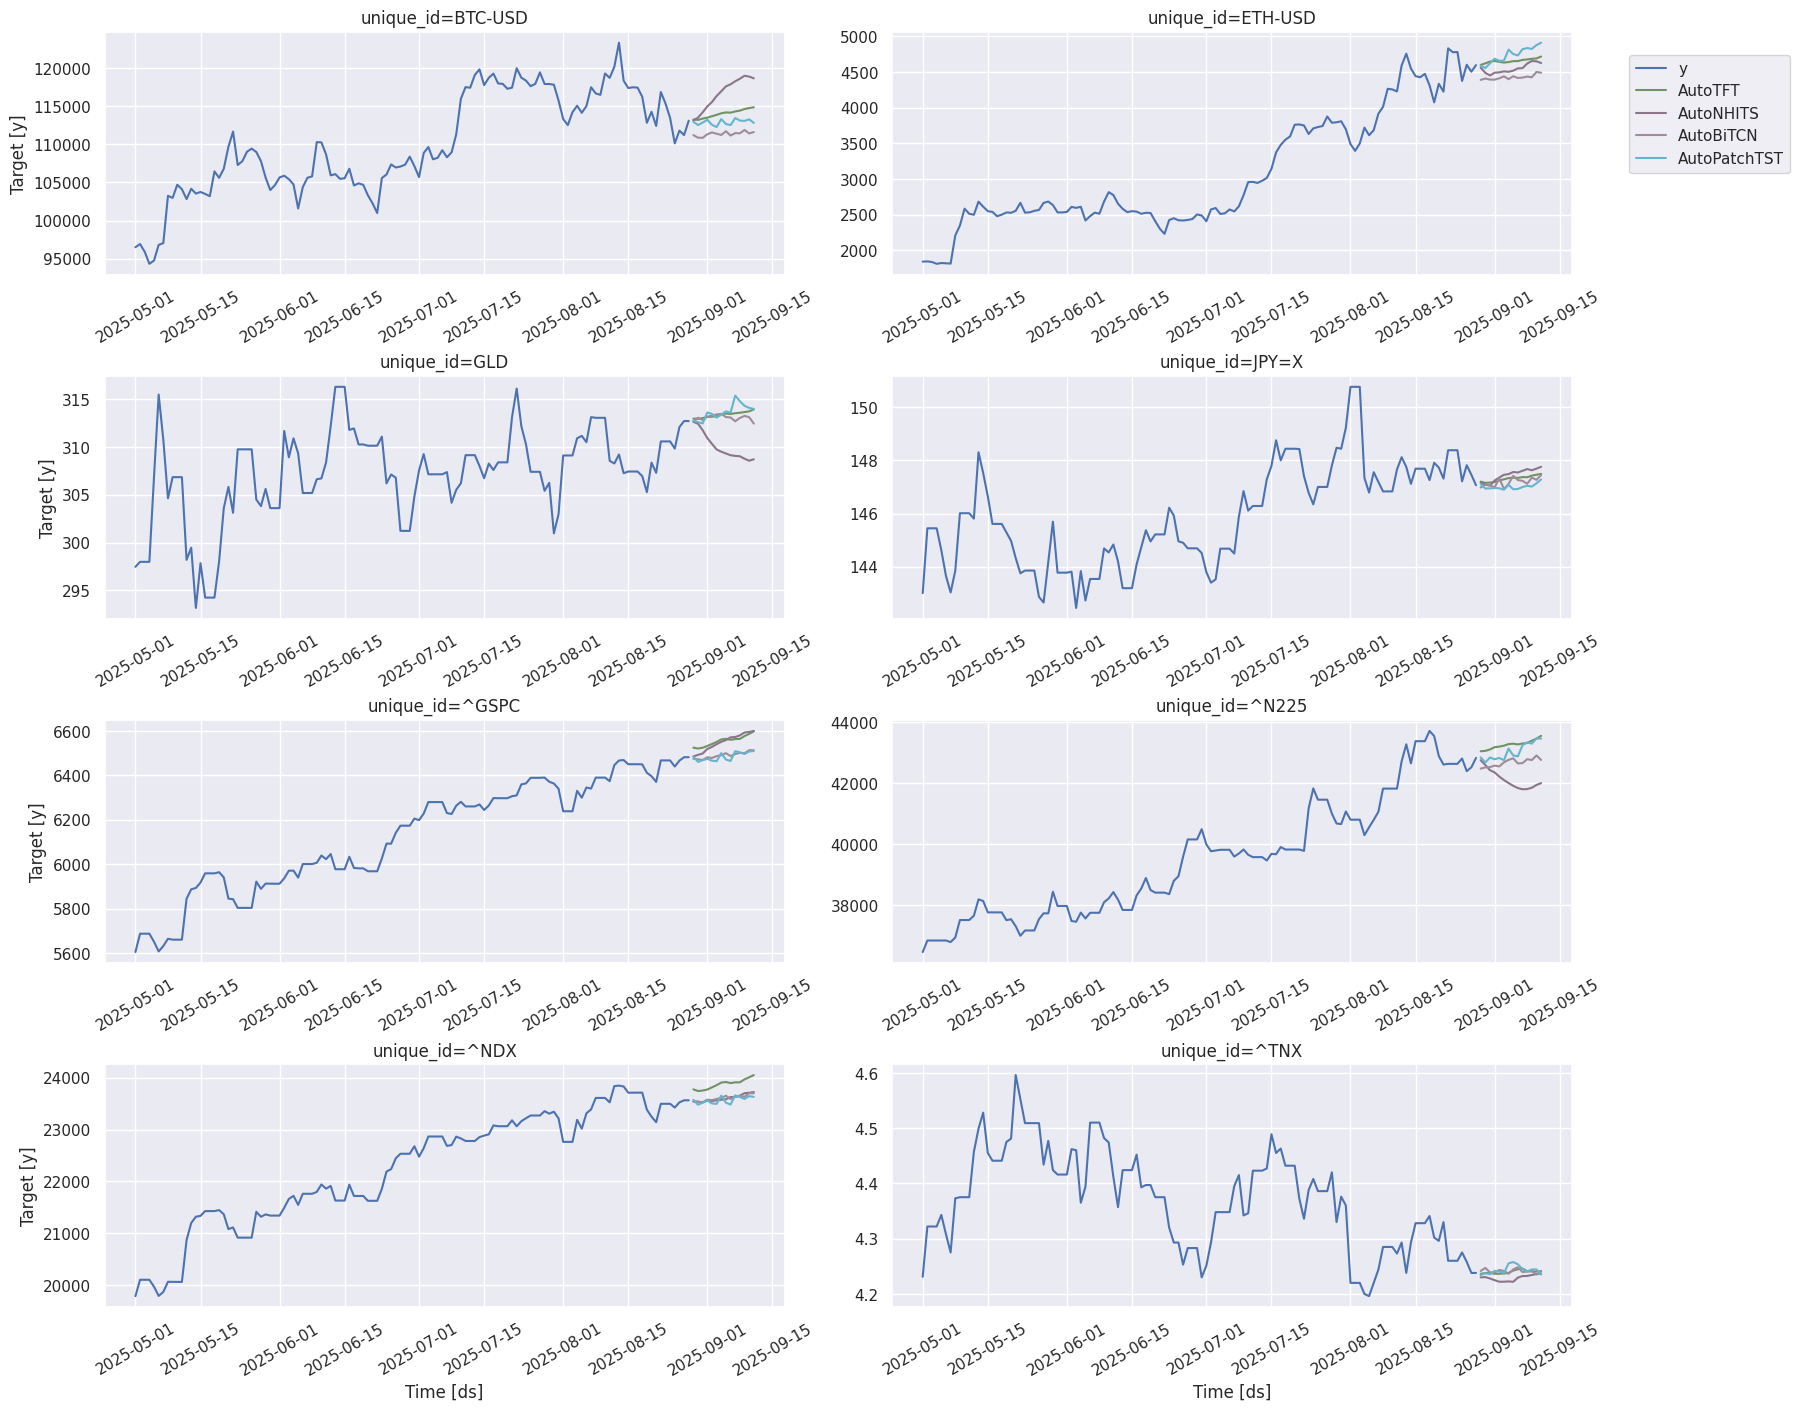

In [14]:
plot_series(df, pred, max_insample_length=24*5)

In [ ]:
results = {i: nf_auto.models[i].results.trials_dataframe() for i in range(len(nf_auto.models))}
results[0]

,number,value,datetime_start,datetime_complete,duration,params_hidden_size,params_input_size,params_learning_rate,params_n_head,params_n_rnn_layers,params_random_seed,user_attrs_ALL_PARAMS,user_attrs_METRICS,state
0,0,621.445312,2025-08-28 23:16:41.370816,2025-08-28 23:18:55.721434,0 days 00:02:14.350618,32,168,0.001928,4,2,8,"{'input_size': 168, 'hidden_size': 32, 'n_head...","{'loss': tensor(621.4453), 'train_loss': tenso...",COMPLETE
1,1,705.931396,2025-08-28 23:18:55.721954,2025-08-28 23:21:02.191038,0 days 00:02:06.469084,32,168,0.000522,4,1,6,"{'input_size': 168, 'hidden_size': 32, 'n_head...","{'loss': tensor(705.9314), 'train_loss': tenso...",COMPLETE
2,2,713.172607,2025-08-28 23:21:02.191122,2025-08-28 23:21:59.211962,0 days 00:00:57.020840,16,84,0.000511,4,3,8,"{'input_size': 84, 'hidden_size': 16, 'n_head'...","{'loss': tensor(713.1726), 'train_loss': tenso...",COMPLETE
3,3,710.567688,2025-08-28 23:21:59.212000,2025-08-28 23:24:23.780921,0 days 00:02:24.568921,64,168,0.000183,2,1,6,"{'input_size': 168, 'hidden_size': 64, 'n_head...","{'loss': tensor(710.5677), 'train_loss': tenso...",COMPLETE
4,4,767.113098,2025-08-28 23:24:23.780961,2025-08-28 23:26:41.449840,0 days 00:02:17.668879,32,168,0.001411,4,3,4,"{'input_size': 168, 'hidden_size': 32, 'n_head...","{'loss': tensor(767.1131), 'train_loss': tenso...",COMPLETE
5,5,766.094055,2025-08-28 23:26:41.449883,2025-08-28 23:27:31.434100,0 days 00:00:49.984217,16,84,0.000113,2,1,6,"{'input_size': 84, 'hidden_size': 16, 'n_head'...","{'loss': tensor(766.0941), 'train_loss': tenso...",COMPLETE
6,6,803.455872,2025-08-28 23:27:31.434138,2025-08-28 23:29:23.197179,0 days 00:01:51.763041,32,168,0.001320,2,3,4,"{'input_size': 168, 'hidden_size': 32, 'n_head...","{'loss': tensor(803.4559), 'train_loss': tenso...",COMPLETE
7,7,716.111694,2025-08-28 23:29:23.197218,2025-08-28 23:30:56.169588,0 days 00:01:32.972370,32,168,0.000258,1,2,8,"{'input_size': 168, 'hidden_size': 32, 'n_head...","{'loss': tensor(716.1117), 'train_loss': tenso...",COMPLETE
8,8,729.395081,2025-08-28 23:30:56.169624,2025-08-28 23:31:43.144997,0 days 00:00:46.975373,8,84,0.000921,4,1,7,"{'input_size': 84, 'hidden_size': 8, 'n_head':...","{'loss': tensor(729.3951), 'train_loss': tenso...",COMPLETE
9,9,711.613403,2025-08-28 23:31:43.145081,2025-08-28 23:33:47.874813,0 days 00:02:04.729732,32,168,0.001534,4,1,8,"{'input_size': 168, 'hidden_size': 32, 'n_head...","{'loss': tensor(711.6134), 'train_loss': tenso...",COMPLETE


In [20]:
results[1]

,number,value,datetime_start,datetime_complete,duration,params_input_size,params_learning_rate,params_n_pool_kernel_size,params_random_seed,user_attrs_ALL_PARAMS,user_attrs_METRICS,state
0,0,673.278137,2025-08-28 23:35:59.294500,2025-08-28 23:36:16.091897,0 days 00:00:16.797397,168,0.001112,"[16, 8, 1]",8,"{'input_size': 168, 'learning_rate': 0.0011121...","{'loss': tensor(673.2781), 'train_loss': tenso...",COMPLETE
1,1,694.273804,2025-08-28 23:36:16.091938,2025-08-28 23:36:34.855264,0 days 00:00:18.763326,84,0.004468,"[16, 8, 1]",9,"{'input_size': 84, 'learning_rate': 0.00446811...","{'loss': tensor(694.2738), 'train_loss': tenso...",COMPLETE
2,2,643.797485,2025-08-28 23:36:34.855299,2025-08-28 23:36:55.351474,0 days 00:00:20.496175,84,0.000134,"[2, 2, 2]",6,"{'input_size': 84, 'learning_rate': 0.00013414...","{'loss': tensor(643.7975), 'train_loss': tenso...",COMPLETE
3,3,644.719666,2025-08-28 23:36:55.351511,2025-08-28 23:37:15.320898,0 days 00:00:19.969387,84,0.000670,"[16, 8, 1]",6,"{'input_size': 84, 'learning_rate': 0.00066955...","{'loss': tensor(644.7197), 'train_loss': tenso...",COMPLETE
4,4,914.935791,2025-08-28 23:37:15.320932,2025-08-28 23:37:32.661617,0 days 00:00:17.340685,168,0.001623,"[16, 8, 1]",1,"{'input_size': 168, 'learning_rate': 0.0016230...","{'loss': tensor(914.9358), 'train_loss': tenso...",COMPLETE
5,5,811.214233,2025-08-28 23:37:32.661653,2025-08-28 23:37:51.068830,0 days 00:00:18.407177,112,0.001434,"[16, 8, 1]",9,"{'input_size': 112, 'learning_rate': 0.0014342...","{'loss': tensor(811.2142), 'train_loss': tenso...",COMPLETE
6,6,741.598206,2025-08-28 23:37:51.068869,2025-08-28 23:38:08.276288,0 days 00:00:17.207419,112,0.000224,"[2, 2, 2]",9,"{'input_size': 112, 'learning_rate': 0.0002237...","{'loss': tensor(741.5982), 'train_loss': tenso...",COMPLETE
7,7,681.316956,2025-08-28 23:38:08.276322,2025-08-28 23:38:24.546250,0 days 00:00:16.269928,112,0.004095,"[2, 2, 2]",6,"{'input_size': 112, 'learning_rate': 0.0040948...","{'loss': tensor(681.3170), 'train_loss': tenso...",COMPLETE
8,8,731.673950,2025-08-28 23:38:24.546283,2025-08-28 23:38:40.096511,0 days 00:00:15.550228,168,0.000462,"[2, 2, 2]",2,"{'input_size': 168, 'learning_rate': 0.0004618...","{'loss': tensor(731.6740), 'train_loss': tenso...",COMPLETE
9,9,934.330383,2025-08-28 23:38:40.096547,2025-08-28 23:38:57.192507,0 days 00:00:17.095960,112,0.000444,"[2, 2, 2]",5,"{'input_size': 112, 'learning_rate': 0.0004435...","{'loss': tensor(934.3304), 'train_loss': tenso...",COMPLETE


In [21]:
results[2]

,number,value,datetime_start,datetime_complete,duration,params_hidden_size,params_input_size,params_learning_rate,params_random_seed,user_attrs_ALL_PARAMS,user_attrs_METRICS,state
0,0,794.505188,2025-08-28 23:39:15.290907,2025-08-28 23:41:25.412925,0 days 00:02:10.122018,64,112,0.001171,4,"{'input_size': 112, 'hidden_size': 64, 'learni...","{'loss': tensor(794.5052), 'train_loss': tenso...",COMPLETE
1,1,779.624207,2025-08-28 23:41:25.412966,2025-08-28 23:42:22.282025,0 days 00:00:56.869059,32,112,0.004175,7,"{'input_size': 112, 'hidden_size': 32, 'learni...","{'loss': tensor(779.6242), 'train_loss': tenso...",COMPLETE
2,2,995.335571,2025-08-28 23:42:22.282067,2025-08-28 23:42:52.910691,0 days 00:00:30.628624,16,112,0.005085,10,"{'input_size': 112, 'hidden_size': 16, 'learni...","{'loss': tensor(995.3356), 'train_loss': tenso...",COMPLETE
3,3,995.337524,2025-08-28 23:42:52.910731,2025-08-28 23:43:39.666550,0 days 00:00:46.755819,16,168,0.006716,5,"{'input_size': 168, 'hidden_size': 16, 'learni...","{'loss': tensor(995.3375), 'train_loss': tenso...",COMPLETE
4,4,672.885132,2025-08-28 23:43:39.666590,2025-08-28 23:44:36.873599,0 days 00:00:57.207009,32,112,0.000206,10,"{'input_size': 112, 'hidden_size': 32, 'learni...","{'loss': tensor(672.8851), 'train_loss': tenso...",COMPLETE
5,5,725.691528,2025-08-28 23:44:36.873637,2025-08-28 23:46:22.373766,0 days 00:01:45.500129,32,168,0.000289,4,"{'input_size': 168, 'hidden_size': 32, 'learni...","{'loss': tensor(725.6915), 'train_loss': tenso...",COMPLETE
6,6,771.744934,2025-08-28 23:46:22.373804,2025-08-28 23:46:50.626339,0 days 00:00:28.252535,16,84,0.009049,6,"{'input_size': 84, 'hidden_size': 16, 'learnin...","{'loss': tensor(771.7449), 'train_loss': tenso...",COMPLETE
7,7,704.119507,2025-08-28 23:46:50.626381,2025-08-28 23:48:37.184314,0 days 00:01:46.557933,64,84,0.000192,6,"{'input_size': 84, 'hidden_size': 64, 'learnin...","{'loss': tensor(704.1195), 'train_loss': tenso...",COMPLETE
8,8,692.142212,2025-08-28 23:48:37.184365,2025-08-28 23:49:23.342966,0 days 00:00:46.158601,32,84,0.002438,1,"{'input_size': 84, 'hidden_size': 32, 'learnin...","{'loss': tensor(692.1422), 'train_loss': tenso...",COMPLETE
9,9,732.615540,2025-08-28 23:49:23.343009,2025-08-28 23:51:41.164587,0 days 00:02:17.821578,64,112,0.000792,7,"{'input_size': 112, 'hidden_size': 64, 'learni...","{'loss': tensor(732.6155), 'train_loss': tenso...",COMPLETE


In [22]:
results[3]

,number,value,datetime_start,datetime_complete,duration,params_input_size,params_learning_rate,params_patch_len,params_random_seed,params_revin,params_stride,user_attrs_ALL_PARAMS,user_attrs_METRICS,state
0,0,798.486328,2025-08-28 23:52:40.647729,2025-08-28 23:53:47.475148,0 days 00:01:06.827419,168,0.003669,7,2,False,7,"{'input_size': 168, 'stride': 7, 'patch_len': ...","{'loss': tensor(798.4863), 'train_loss': tenso...",COMPLETE
1,1,635.087524,2025-08-28 23:53:47.475186,2025-08-28 23:58:18.079844,0 days 00:04:30.604658,168,0.000687,4,8,True,2,"{'input_size': 168, 'stride': 2, 'patch_len': ...","{'loss': tensor(635.0875), 'train_loss': tenso...",COMPLETE
2,2,672.828125,2025-08-28 23:58:18.079886,2025-08-29 02:26:45.613820,0 days 02:28:27.533934,168,0.000350,7,6,True,1,"{'input_size': 168, 'stride': 1, 'patch_len': ...","{'loss': tensor(672.8281), 'train_loss': tenso...",COMPLETE
3,3,705.491943,2025-08-29 02:26:45.615988,2025-08-29 02:31:27.501425,0 days 00:04:41.885437,84,0.001396,1,2,True,1,"{'input_size': 84, 'stride': 1, 'patch_len': 1...","{'loss': tensor(705.4919), 'train_loss': tenso...",COMPLETE
4,4,705.340637,2025-08-29 02:31:27.501552,2025-08-29 02:33:16.186269,0 days 00:01:48.684717,84,0.000123,1,7,True,2,"{'input_size': 84, 'stride': 2, 'patch_len': 1...","{'loss': tensor(705.3406), 'train_loss': tenso...",COMPLETE
5,5,637.524475,2025-08-29 02:33:16.186311,2025-08-29 02:33:46.723970,0 days 00:00:30.537659,84,0.000803,14,10,False,7,"{'input_size': 84, 'stride': 7, 'patch_len': 1...","{'loss': tensor(637.5245), 'train_loss': tenso...",COMPLETE
6,6,645.246338,2025-08-29 02:33:46.724017,2025-08-29 04:46:55.144522,0 days 02:13:08.420505,168,0.001563,14,9,False,1,"{'input_size': 168, 'stride': 1, 'patch_len': ...","{'loss': tensor(645.2463), 'train_loss': tenso...",COMPLETE
7,7,669.631836,2025-08-29 04:46:55.144944,2025-08-29 04:47:28.485705,0 days 00:00:33.340761,84,0.000166,7,5,False,7,"{'input_size': 84, 'stride': 7, 'patch_len': 7...","{'loss': tensor(669.6318), 'train_loss': tenso...",COMPLETE
8,8,797.912354,2025-08-29 04:47:28.485747,2025-08-29 04:52:52.831653,0 days 00:05:24.345906,112,0.000732,14,5,False,1,"{'input_size': 112, 'stride': 1, 'patch_len': ...","{'loss': tensor(797.9124), 'train_loss': tenso...",COMPLETE
9,9,691.749329,2025-08-29 04:52:52.831724,2025-08-29 04:53:20.160399,0 days 00:00:27.328675,84,0.009542,4,4,False,14,"{'input_size': 84, 'stride': 14, 'patch_len': ...","{'loss': tensor(691.7493), 'train_loss': tenso...",COMPLETE


In [7]:
horizon = 14

models = [
    PatchTST(h=horizon,
        input_size=168,
        patch_len=4,
        stride=2,
        scaler_type='robust',
        loss=MAE(),
        revin=True,
        learning_rate=6.87e-4,
        max_steps=1000,
            ),
    TFT(h=horizon,
        n_head=4,
        n_rnn_layers=2,
        rnn_type='lstm',
        input_size=168,
        hidden_size=32, 
        learning_rate=1.928e-3,
        max_steps=1000,
        futr_exog_list=['day_week'], # <- Future exogenous variables
        stat_exog_list=['crypto', 'equity', 'bond'], # <- Static ex
        scaler_type='robust',
        loss=MAE(),
        ),
    NHITS(h=horizon,
        max_steps=1000,
        input_size = 84,
        learning_rate=1.34e-4,
        n_pool_kernel_size = [2, 2, 2],
        futr_exog_list = ['day_week'], # <- Future exogenous variables
        stat_exog_list = ['crypto', 'equity', 'bond'], # <- Static exogenous variables
        scaler_type = 'robust',
        loss=MAE(),
        ),
    BiTCN(h=horizon,
        input_size = 112,
        hidden_size = 32,
        learning_rate=2.06e-4,
        max_steps=1000,
        futr_exog_list = ['day_week'], # <- Future exogenous variables
        stat_exog_list = ['crypto', 'equity', 'bond'], # <- Static exogenous variables
        scaler_type = 'robust',
        loss=MAE(),
        ),  
    ]

nf = NeuralForecast(
    models=models,
    freq='D'
)
cv_df = nf.cross_validation(df=df, static_df=static_df, n_windows=2)


Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, v_num=114, train_loss_step=0.702, train_loss_epoch=0.702]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s, v_num=114, train_loss_step=0.702, train_loss_epoch=0.702]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jhyunbin/quant/patchTST/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.18it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s, v_num=116, train_loss_step=0.709, train_loss_epoch=0.709]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, v_num=116, train_loss_step=0.709, train_loss_epoch=0.709]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 41.86it/s, v_num=118, train_loss_step=0.572, train_loss_epoch=0.572] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s, v_num=118, train_loss_step=0.572, train_loss_epoch=0.572]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.24it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s, v_num=120, train_loss_step=0.954, train_loss_epoch=0.954]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s, v_num=120, train_loss_step=0.954, train_loss_epoch=0.954]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


In [9]:
cv_df.head()

,unique_id,ds,cutoff,PatchTST,TFT,NHITS,BiTCN,y
0,BTC-USD,2025-08-14,2025-08-13,123416.765625,123861.031250,123096.390625,119291.968750,118359.578125
1,BTC-USD,2025-08-15,2025-08-13,122997.171875,124046.546875,123206.914062,119537.453125,117398.351562
2,BTC-USD,2025-08-16,2025-08-13,123619.351562,124073.765625,123137.531250,119508.937500,117491.351562
3,BTC-USD,2025-08-17,2025-08-13,123614.960938,123815.054688,122696.187500,119758.945312,117453.062500
4,BTC-USD,2025-08-18,2025-08-13,123596.109375,124004.968750,122234.929688,120197.765625,116252.312500


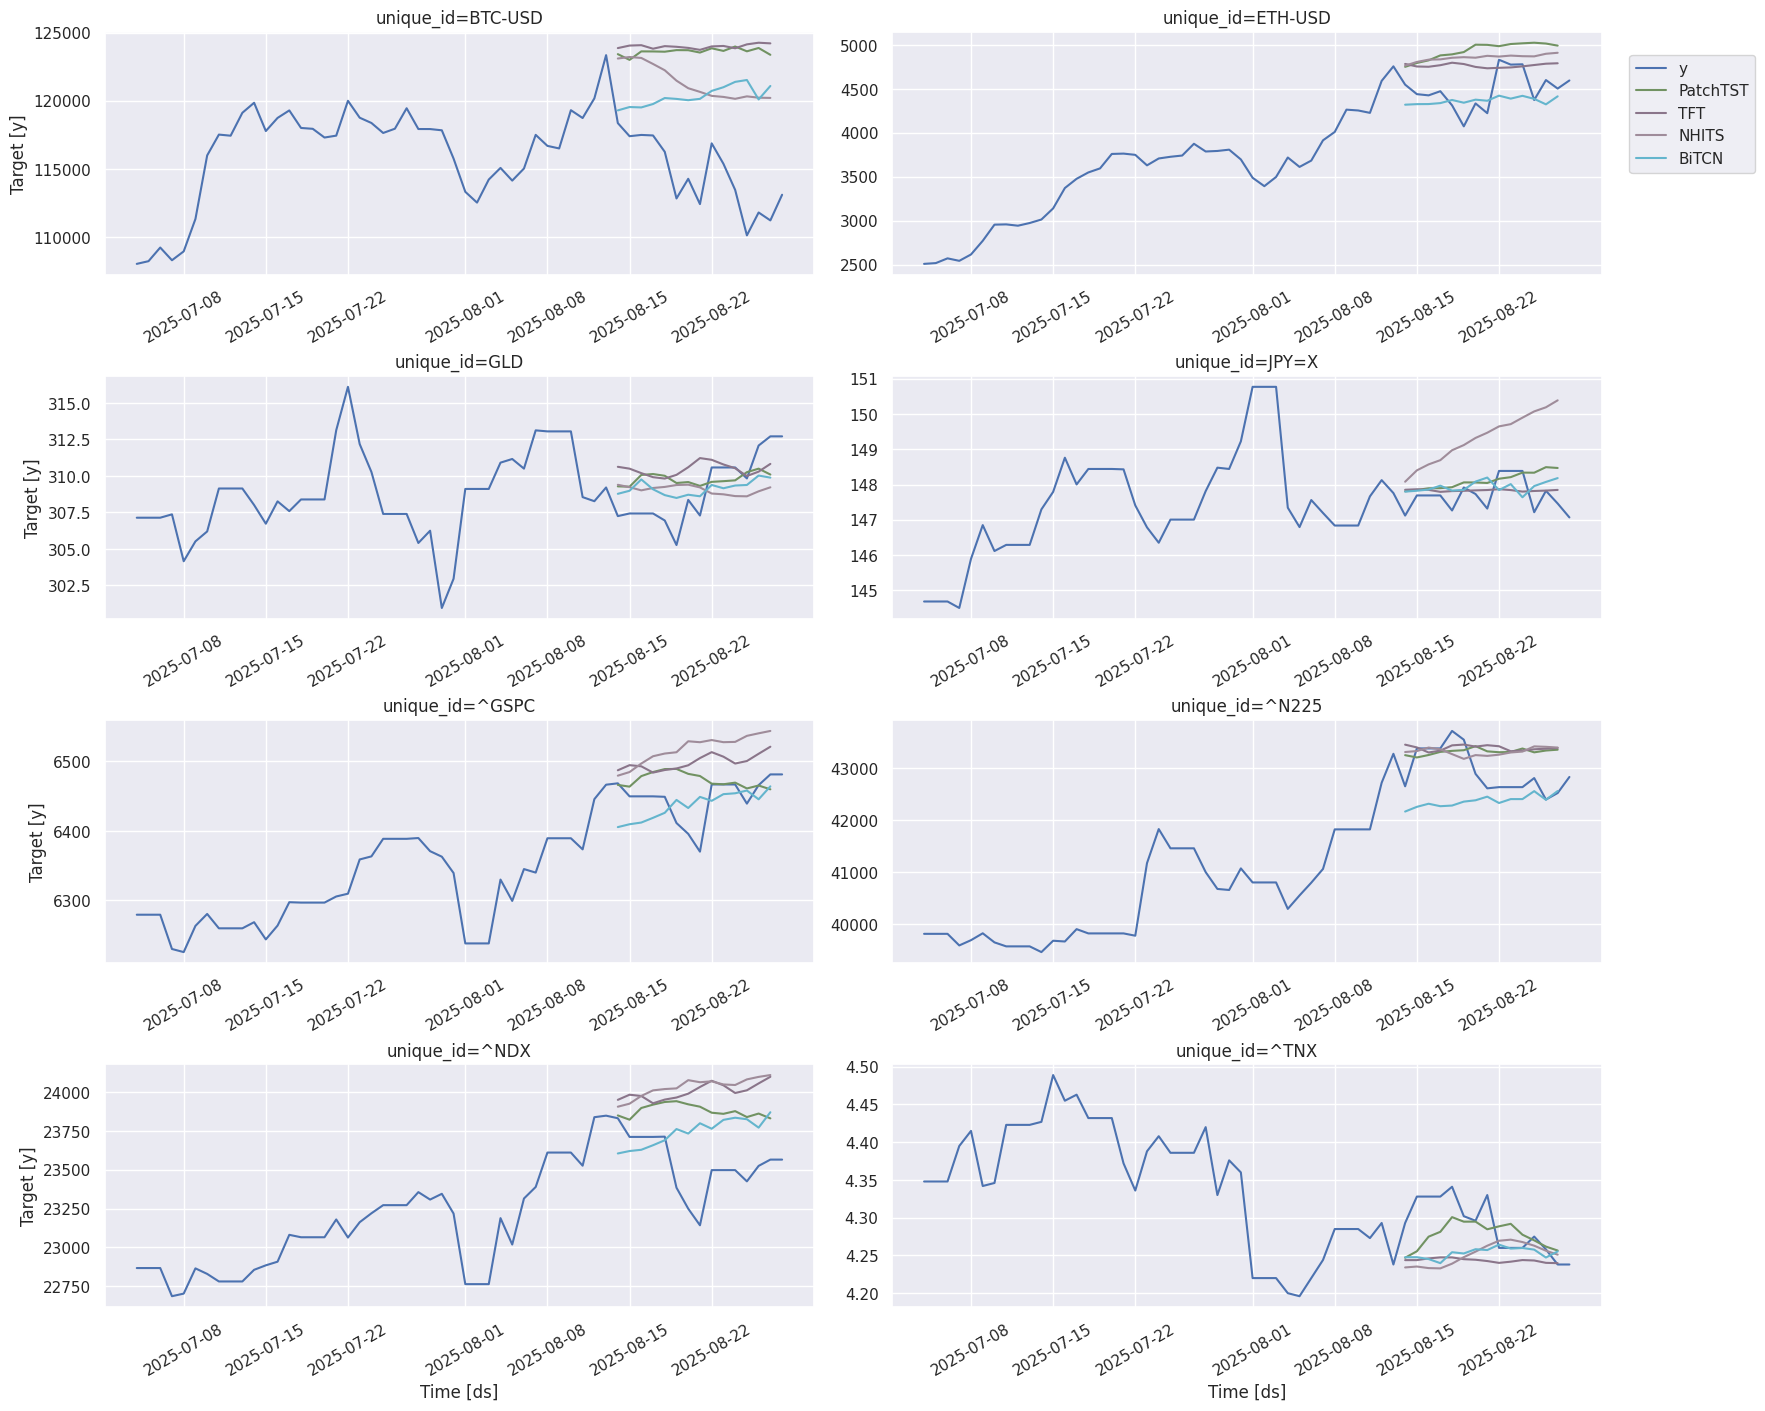

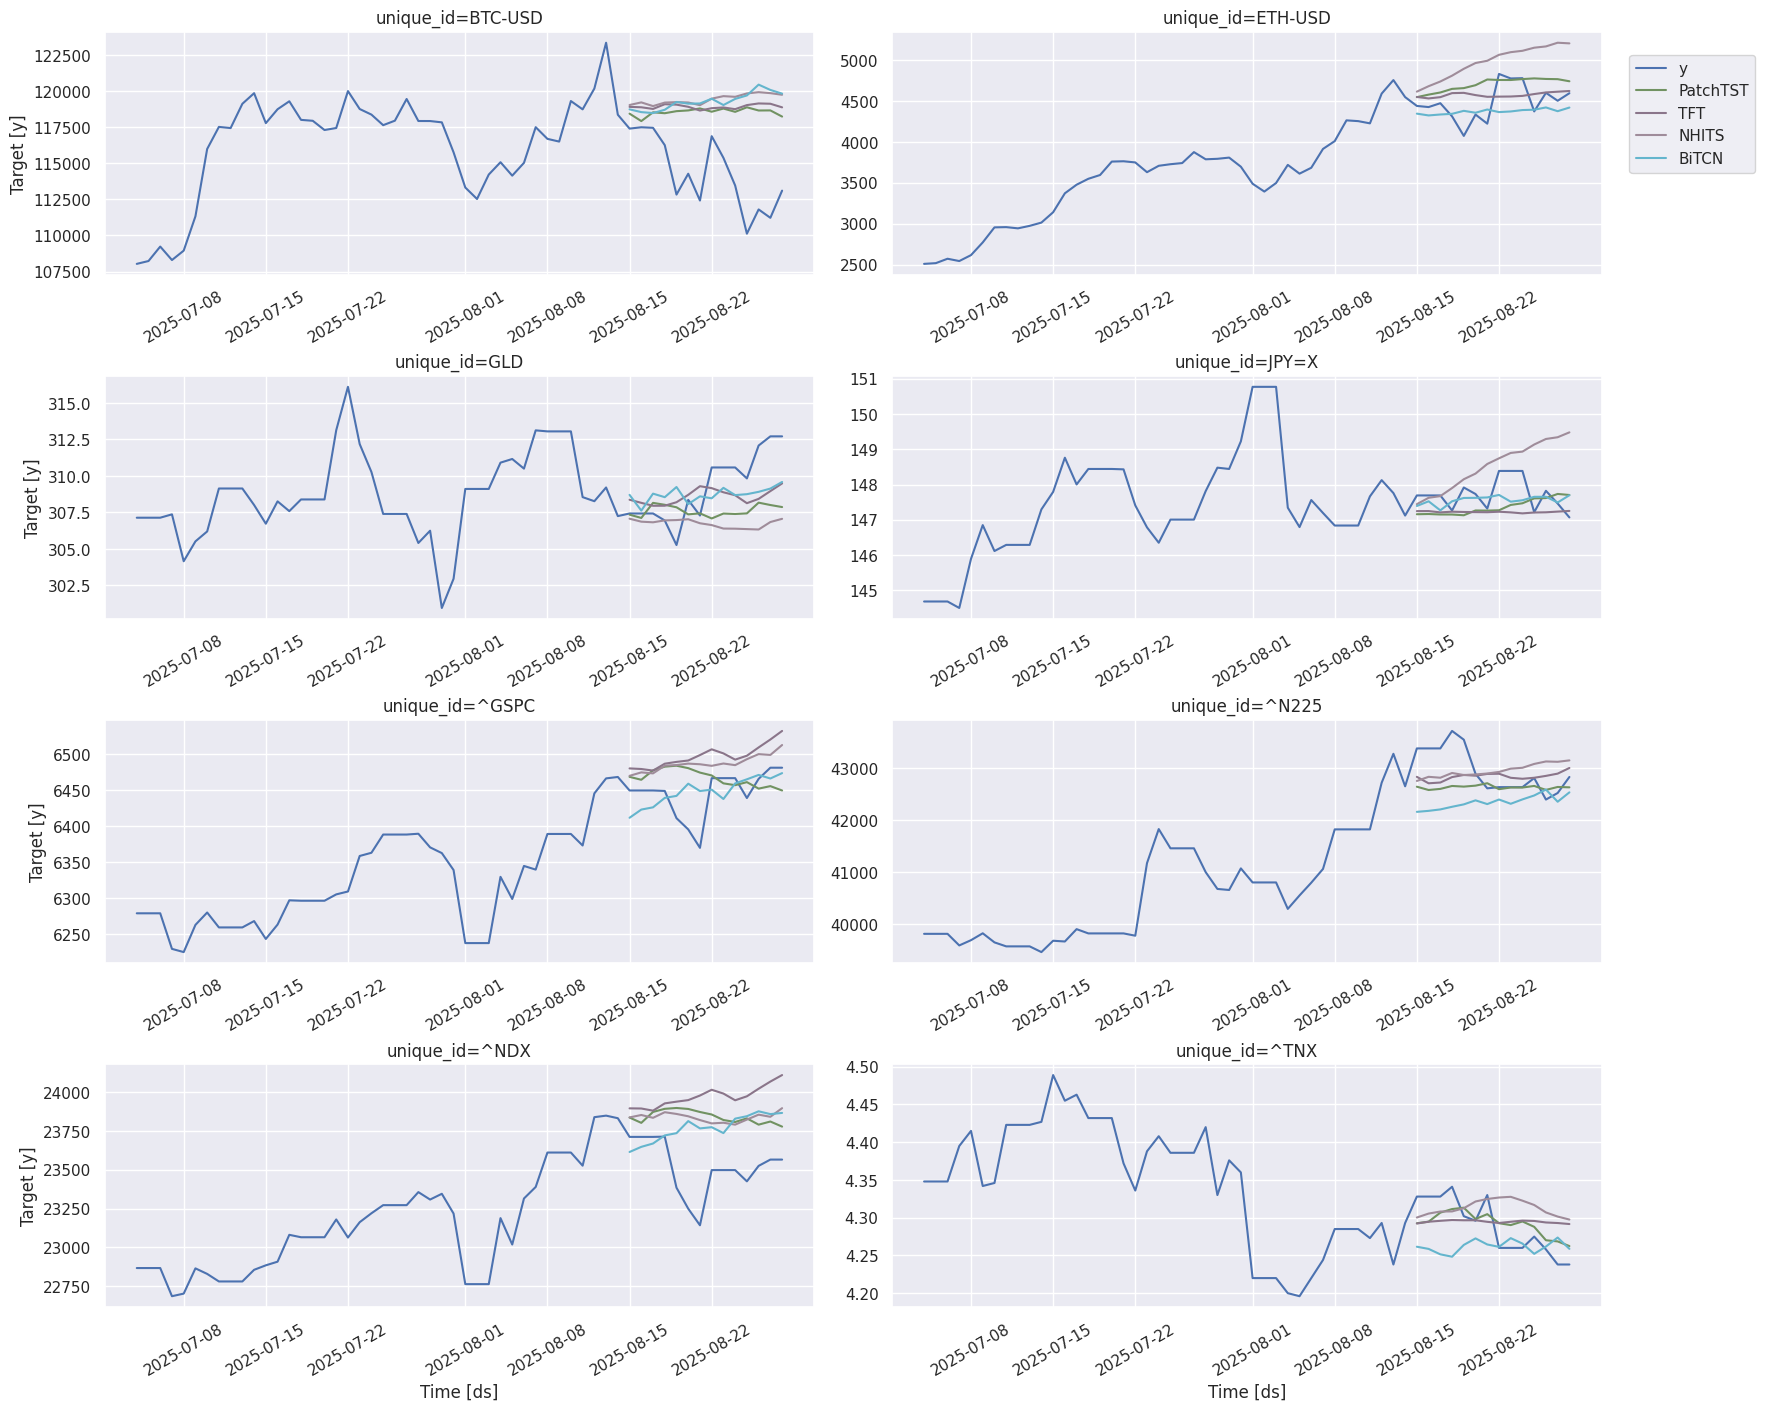

In [14]:
from IPython.display import display

for cutoff in cv_df['cutoff'].unique():
    display(
        plot_series(
            df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=14 * 4, 
            # ids=['H102'],
        )
    )

In [13]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse

evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mse, mae, rmse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df

,unique_id,metric,PatchTST,TFT,NHITS,BiTCN,best_model
0,BTC-USD,mse,5.594747e+07,6.075030e+07,4.075572e+07,3.739510e+07,BiTCN
1,ETH-USD,mse,1.708432e+05,9.245865e+04,2.414642e+05,5.346815e+04,BiTCN
2,GLD,mse,6.256415e+00,5.645895e+00,8.641007e+00,4.033393e+00,BiTCN
3,JPY=X,mse,3.528813e-01,3.082200e-01,2.182456e+00,2.510880e-01,BiTCN
4,^GSPC,mse,2.093978e+03,3.635917e+03,4.673920e+03,1.260423e+03,BiTCN
5,^N225,mse,3.063246e+05,2.969715e+05,2.996976e+05,5.970659e+05,TFT
6,^NDX,mse,1.506133e+05,2.564084e+05,2.171257e+05,1.089317e+05,BiTCN
7,^TNX,mse,1.004806e-03,2.327788e-03,2.799810e-03,2.606032e-03,PatchTST
8,BTC-USD,mae,6.601792e+03,6.971843e+03,5.908830e+03,5.318826e+03,BiTCN
9,ETH-USD,mae,3.470582e+02,2.517710e+02,4.377633e+02,1.876354e+02,BiTCN


The results show that Bidirectional Temporal Convolutional Network(BiTCN) shows high performance on most instruments. Only two (Nikkei 225 and 10 Y interest) lost against PatchTST and TFT(Temporal Fusion Transformer). 

It's interesting to see how a small model defeats many heavy transformer based models and even MLP based models. 

One theory is because of the lack of exploration in the hyperparameter space. I only used 10 `sample_size` and since BiTCN has only two hyperparameters, it must have taken huge advantage of having only 10 explorations. 

I believe with a vast dataset with much more multichannels that might correlate with cryptocurrency prices, the performance of transformer based models will excel. However due to the lack of resources (even fitting the auto model for PatchTST took 5 hours with 10 `sample_size` using RTX 4060Ti) I will leave that for later. 

In [ ]:
nf.save(path='./models/v3/',
        model_index=None,
        overwrite=True,
        save_dataset=False)

In [ ]:
version = 1

nf = NeuralForecast.load(path=f'./models/v{version}/')

print(f"Loaded model: v{version}")